In [18]:
import QuantLib as ql
import numpy as np
from timeit import default_timer as timer
from scipy.stats import norm
from math import *

class Option:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.bs_price = -1
        self.mc_price = -1
        self.delta = -1
        self.gamma = -1
        self.vega = -1
        self.rho = -1
        self.theta = -1
        
    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        bs_price = european_option.NPV()
        self.bs_price = bs_price
        return self.bs_price
    
    def BSM_Greeks(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        time_bs_start = timer()
        bs_price = european_option.NPV()
        self.delta = european_option.delta()
        self.gamma = european_option.gamma() #second order
        self.vega = european_option.vega()
        self.rho = european_option.rho()
        self.theta = european_option.theta()
        time_bs_end = timer()
        time_bs = time_bs_end - time_bs_start
        greeks_output = [(self.delta, self.gamma, self.rho, self.vega, self.theta, time_bs)]
        dataframe = pd.DataFrame(greeks_output)
        dataframe.columns = ['delta', 'gamma', 'rho', 'vega', 'theta', 'time']
        return dataframe


    def data_set_delta(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        if self.delta == -1:
            self.BSM_Greeks()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate,self.bs_price, self.delta, self.gamma, self.vega, self.rho, self.theta)
        return data_set

    
class BasketOption:
    def __init__(self, calculation_date, maturity, strike_price, risk_free_rate, option_type, options_number, options_raw, corr, w1, w2):
        self.maturity = maturity
        self.options_number = options_number
        self.options_raw = options_raw
        self.strike_price = strike_price
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.corr = corr
        self.w1 = w1
        self.w2 = w2
        self.price_mc = -1
        self.price_mm = -1
        self.mm_time = -1
        
    def mc_price(self):
        # global data
        ql.Settings.instance().evaluationDate = self.calculation_date
        riskFreeRate = ql.FlatForward(self.calculation_date, self.risk_free_rate, ql.Actual365Fixed())

        # option parameters
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        
        # market data
        options = []
        processes = []
        for i in range(self.options_number):
            option = {}
            option['stock_price'] = ql.SimpleQuote(self.options_raw[i][0])
            option['volatility'] = ql.BlackConstantVol(self.calculation_date, calendar, self.options_raw[i][1], ql.Actual365Fixed())
            option['dividend'] = ql.FlatForward(self.calculation_date,self.options_raw[i][2], ql.Actual365Fixed())
            option['process'] = ql.BlackScholesMertonProcess(
                        ql.QuoteHandle(option['stock_price']),
                        ql.YieldTermStructureHandle(option['dividend']),
                        ql.YieldTermStructureHandle(riskFreeRate),
                        ql.BlackVolTermStructureHandle(option['volatility']),
                    )
            processes.append(option['process'])
            options.append(option)
        matrix = ql.Matrix(self.options_number, self.options_number)
        for j in range(self.options_number):
            for k in range(self.options_number):
                if j == k:
                    matrix[j][k] = 1.0
                else:
                    matrix[j][k] = corr
        process = ql.StochasticProcessArray(processes, matrix)
        basketoption = ql.BasketOption(ql.MaxBasketPayoff(payoff), exercise)
        basketoption.setPricingEngine(
            ql.MCEuropeanBasketEngine(process, "pseudorandom",  requiredTolerance=0.02, seed=42,timeSteps = 100000)
        )
        self.price_mc = basketoption.NPV()
        return basketoption.NPV()

    def mm_price(self):
        S1 = self.options_raw[0][0]
        S2 = self.options_raw[1][0]
        T = int(self.maturity - self.calculation_date)/365
        sigma1 = self.options_raw[0][1]
        sigma2 = self.options_raw[1][1]
        rdom = self.risk_free_rate
        corr = self.corr
        w1 = self.w1
        w2 = self.w2
        K = self.strike_price
        #rdom, rCCY1,rCCY2 are the interest rates for domestic and foreign currencies
        #corr is the correlation of the currencies
        if self.option_type == ql.Option.Call:
            pc = 1
        else:
            pc = -1
        SBasket = (w1*S1+w2*S2)
        mu = (1/T) * log((w1*S1*exp((rdom)*T)+w2*S2*exp((rdom)*T))/SBasket)
        sigma= sqrt((1/T) * log(((S1**2)*exp((sigma1**2)*T)+(S2**2)*exp((sigma2**2)*T)+2*S1*S2*
                                 exp(corr*sigma1*sigma2*T))/(S1+S2)**2))
        FBasket = SBasket*exp(mu*T)
        d1 = (log(FBasket/K)+0.5*sigma**2*T)/(sigma*sqrt(T))
        d2 = d1-sigma*sqrt(T)
        V = exp(-rdom*T)*(pc*FBasket*norm.cdf(pc*d1)-pc*K*norm.cdf(pc*d2))
        self.price_mm = V
        return(V)
    
    def mm_price_greeks(self):
        if self.price_mm == -1:
            self.mm_price()
        S1 = self.options_raw[0][0]
        S2 = self.options_raw[1][0]
        sigma1 = self.options_raw[0][1]
        sigma2 = self.options_raw[1][1]
        dividend1 = self.options_raw[0][2]
        dividend2 = self.options_raw[1][2]
        dividend_rate = self.options_raw[0][2]
        stock1 = Option(self.calculation_date, self.maturity, S1, self.strike_price, sigma1, dividend1, self.risk_free_rate, self.option_type)
        stock2 = Option(self.calculation_date, self.maturity, S2, self.strike_price, sigma2, dividend2, self.risk_free_rate, self.option_type)
        stock1_greeks = stock1.BSM_Greeks()
        stock2_greeks = stock2.BSM_Greeks()
        delta = stock1_greeks['delta'].values[0]*w1 + stock2_greeks['delta'].values[0]*w2
        gamma = stock1_greeks['gamma'].values[0]*w1 + stock2_greeks['gamma'].values[0]*w2
        rho = stock1_greeks['rho'].values[0]*w1 + stock2_greeks['rho'].values[0]*w2
        vega = stock1_greeks['vega'].values[0]*w1 + stock2_greeks['vega'].values[0]*w2
        theta = stock1_greeks['theta'].values[0]*w1 + stock2_greeks['theta'].values[0]*w2
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (S1, S2, sigma1, sigma2, self.corr, self.strike_price, maturity_in_year, dividend_rate, self.risk_free_rate, self.price_mm, delta, gamma, rho, vega, theta)
        return data_set
    
    def mc_stats(self):
        time_mc_start = timer()
        mc_price = self.mc_price()
        time_mc_end = timer()
        time_mc = time_mc_end - time_mc_start
        return (mc_price, time_mc)
    
    def mm_stats(self):
        time_mm_start = timer()
        mm_price = self.mm_price()
        time_mm_end = timer()
        time_mm = time_mm_end - time_mm_start
        self.mm_time = time_mm
        return (mm_price, time_mm)     
    
    def mm_dataset(self):
        if self.price_mm == -1:
            self.mm_stats()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        S1 = self.options_raw[0][0]
        S2 = self.options_raw[1][0]
        sigma1 = self.options_raw[0][1]
        sigma2 = self.options_raw[1][1]
        dividend_rate = self.options_raw[0][2]
        data_set = ()
        return data_set
    
    def mc_dataset(self):
        if self.price_mc == -1:
            self.mc_stats()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        S1 = self.options_raw[0][0]
        S2 = self.options_raw[1][0]
        sigma1 = self.options_raw[0][1]
        sigma2 = self.options_raw[1][1]
        dividend_rate = self.options_raw[0][2]
        data_set = (S1, S2, sigma1, sigma2, self.corr, self.strike_price, maturity_in_year, dividend_rate, self.risk_free_rate, self.price_mc)
        return data_set        

In [19]:
from timeit import default_timer as timer

pc = 1 #option type
ATM = 0
calculation_date = ql.Date(15, ql.May, 1998)
maturity = ql.Date(15, ql.May, 1999)
T = int(maturity - calculation_date)/365
strike_price = 8
sigma1 = 0.1
sigma2 = 0.1
w1 = 0.5
w2 = 0.5
S1 = 7
S2 = 7
dividend = 0.05
risk_free_rate = 0.05
corr = 0.5

options_number = 2
options_raw = [[S1, sigma1, dividend],[S2, sigma2, dividend]]
option_type = ql.Option.Call

sample_option = BasketOption(calculation_date, maturity, strike_price, risk_free_rate, option_type, options_number, options_raw, corr, w1, w2)
print(sample_option.mc_stats())
print(sample_option.mm_stats())


(0.0508305640647828, 70.73074789999919)
(0.05631487371914073, 0.0002882999997382285)


In [17]:
print(sample_option.mm_price_greeks())

(7, 7, 0.1, 0.1, 0.5, 8, 1.0, 0.05, 0.05, 0.05631487371914073, 0.09449637030265975, 0.23733573574560168, 0.63145081349413, 1.16294510515345, -0.05664606632644812)


In [8]:
import datetime
import random
import pandas as pd

def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_basket_options(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    w1 = 0.5
    w2 = 0.5
    
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        S1 = 100*(np.random.lognormal(0.5, 0.25))
        S2 = 100*(np.random.lognormal(0.5, 0.25))
        strike_price = random.randint(7, 500)
        sigma1 = random.uniform(0.05, 0.95)
        sigma2 = random.uniform(0.05, 0.95)
        dividend_rate = 0.05
        risk_free_rate = random.uniform(0.001, 0.05)
        option_type = ql.Option.Call
        options_number = 2
        options_raw = [[S1, sigma1, dividend_rate],[S2, sigma2, dividend_rate]]
        option = BasketOption(calculation_date, maturity, strike_price, risk_free_rate, option_type, options_number, options_raw, corr, w1, w2)
        options.append(option)  
    return options


def random_basket_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    w1 = 0.5
    w2 = 0.5
    
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        S1 = 100*(np.random.lognormal(0.5, 0.25))
        S2 = 100*(np.random.lognormal(0.5, 0.25))
        strike_price = random.randint(7, 651)
        sigma1 = random.uniform(0.05, 0.95)
        sigma2 = random.uniform(0.05, 0.95)
        dividend_rate = 0.05
        risk_free_rate = random.uniform(0.001, 0.05)
        option_type = ql.Option.Call
        options_number = 2
        options_raw = [[S1, sigma1, dividend_rate],[S2, sigma2, dividend_rate]]
        option = BasketOption(calculation_date, maturity, strike_price, risk_free_rate, option_type, options_number, options_raw, corr, w1, w2)
        options.append(option.mm_dataset())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['s1', 's2', 'sigma1', 'sigma2', 'corr', 'strike_price', 'maturity', 'devidend','risk_free_rate', 'call_price']
    return dataframe

def random_basket_options_greeks_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    w1 = 0.5
    w2 = 0.5
    
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        S1 = 100*(np.random.lognormal(0.5, 0.25))
        S2 = 100*(np.random.lognormal(0.5, 0.25))
        strike_price = random.randint(7, 651)
        sigma1 = random.uniform(0.05, 0.95)
        sigma2 = random.uniform(0.05, 0.95)
        dividend_rate = 0.05
        risk_free_rate = random.uniform(0.001, 0.05)
        option_type = ql.Option.Call
        options_number = 2
        options_raw = [[S1, sigma1, dividend_rate],[S2, sigma2, dividend_rate]]
        option = BasketOption(calculation_date, maturity, strike_price, risk_free_rate, option_type, options_number, options_raw, corr, w1, w2)
        options.append(option.mm_price_greeks())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['s1', 's2', 'sigma1', 'sigma2', 'corr', 'strike_price', 'maturity', 'devidend','risk_free_rate', 'call_price','delta', 'gamma', 'rho', 'vega', 'theta' ]
    return dataframe

<bound method DataFrame.info of             s1          s2    sigma1    sigma2  corr  strike_price  maturity  \
0   110.016134  174.996756  0.150788  0.255689   0.5           171  1.528767   
1   122.867480  178.247798  0.131267  0.213030   0.5            47  2.419178   
2   165.436994  120.821086  0.783478  0.158975   0.5           376  1.295890   
3   144.763960  124.689731  0.933577  0.181345   0.5           264  1.701370   
4   268.174837  161.578957  0.361111  0.493116   0.5           452  0.578082   
..         ...         ...       ...       ...   ...           ...       ...   
95  156.290668  142.861406  0.339863  0.157660   0.5           499  0.830137   
96  108.230063  242.540787  0.595470  0.655554   0.5           467  2.035616   
97  206.367506  139.420214  0.917172  0.450755   0.5           562  1.183562   
98  230.058251  201.867559  0.228991  0.774431   0.5           397  1.268493   
99  187.943857  221.505430  0.354028  0.307516   0.5           139  0.887671   

    dev

In [55]:
options = random_basket_options_greeks_pd(500000)
n = 500000
df = options.sample(frac=1).reset_index(drop=True)
n_train =  (int)(0.8 * n)
train = df[0:n_train]
test = df[n_train+1:n]
train.to_pickle('basket_random_greeks_train_500k.pkl')
test.to_pickle('basket_random_greeks_test_500k.pkl')

In [56]:
df['call_price'].min()

0.0

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

train = pd.read_pickle('basket_random_greeks_train_500k.pkl')
test = pd.read_pickle('basket_random_greeks_test_500k.pkl')
print(test.columns)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_training = scaler.fit_transform(train)
scaled_testing = scaler.transform(test)
scaled_training_df = pd.DataFrame(scaled_training,columns=train.columns.values)
scaled_testing_df = pd.DataFrame(scaled_testing,columns=test.columns.values)

print("mutiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[6],scaler.min_[6]))
X_train = scaled_training_df[['s1','s2','sigma1', 'sigma2', 'corr', 'strike_price', 'maturity', 'risk_free_rate']].values
y_train = scaled_training_df[['call_price','delta', 'gamma', 'rho', 'vega', 'theta']].values
X_test = scaled_testing_df[['s1','s2','sigma1', 'sigma2', 'corr', 'strike_price', 'maturity', 'risk_free_rate']].values
y_test = scaled_testing_df[['call_price','delta', 'gamma', 'rho', 'vega', 'theta']].values

print("X:", X_train.shape, "Y:",y_train.shape)
 
in_dim = X_train.shape[1]
out_dim = y_train.shape[1]

y_train_price = scaled_training_df['call_price'].values
y_train_delta = scaled_training_df['delta'].values
y_train_gamma = scaled_training_df['gamma'].values
y_train_rho = scaled_training_df['rho'].values
y_train_vega = scaled_training_df['vega'].values
y_train_theta = scaled_training_df['theta'].values

y_test_price = scaled_testing_df['call_price'].values
y_test_delta = scaled_testing_df['delta'].values
y_test_gamma = scaled_testing_df['gamma'].values
y_test_rho = scaled_testing_df['rho'].values
y_test_vega = scaled_testing_df['vega'].values
y_test_theta = scaled_testing_df['theta'].values

in_dim = X_train.shape[1]
out_dim = y_train.shape[1]

Index(['s1', 's2', 'sigma1', 'sigma2', 'corr', 'strike_price', 'maturity',
       'devidend', 'risk_free_rate', 'call_price', 'delta', 'gamma', 'rho',
       'vega', 'theta'],
      dtype='object')
mutiplying by 0.3336380256 and adding -0.001828
X: (400000, 8) Y: (400000, 6)


In [58]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend

inputs = Input(shape=(in_dim,) )
hidden = Dense(50, activation='relu')(inputs)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(50, activation='relu')(hidden)
output1 = Dense(1, activation='linear', name = 'output1')(hidden)
output2 = Dense(1, activation='linear', name = 'output2')(hidden)
output3 = Dense(1, activation='linear', name = 'output3')(hidden)
output4 = Dense(1, activation='linear', name = 'output4')(hidden)
output5 = Dense(1, activation='linear', name = 'output5')(hidden)
output6 = Dense(1, activation='linear', name = 'output6')(hidden)

model = Model(inputs=inputs, outputs=[output1,output2,output3,output4,output5,output6])
model.compile(loss={'output1': 'mse', 
                    'output2': 'mse',
                    'output3': 'mse',
                    'output4': 'mse',
                    'output5': 'mse',
                    'output6': 'mse',},
              loss_weights={'output1': 0.25,
                            'output2': 0.15,
                            'output3': 0.15,
                            'output4': 0.15,
                            'output5': 0.15,
                            'output6': 0.15},
              optimizer='adam',
              metrics={'output1': 'mse', 'output2':'mse', 'output3': 'mse', 'output4': 'mse', 'output5': 'mse', 'output6': 'mse'})

history = model.fit(X_train, [y_train_price, y_train_delta, y_train_gamma, y_train_rho, y_train_vega, y_train_theta], epochs=20, validation_split=0.2, shuffle=True, verbose=2)


Train on 320000 samples, validate on 80000 samples
Epoch 1/20
 - 88s - loss: 5.5274e-04 - output1_loss: 2.1081e-04 - output2_loss: 0.0011 - output3_loss: 2.1001e-04 - output4_loss: 4.1783e-04 - output5_loss: 7.4332e-04 - output6_loss: 8.7136e-04 - output1_mse: 2.1081e-04 - output2_mse: 0.0011 - output3_mse: 2.1001e-04 - output4_mse: 4.1783e-04 - output5_mse: 7.4332e-04 - output6_mse: 8.7136e-04 - val_loss: 8.7461e-05 - val_output1_loss: 3.3326e-05 - val_output2_loss: 1.4634e-04 - val_output3_loss: 9.6017e-05 - val_output4_loss: 6.7216e-05 - val_output5_loss: 1.4404e-04 - val_output6_loss: 7.3911e-05 - val_output1_mse: 3.3326e-05 - val_output2_mse: 1.4634e-04 - val_output3_mse: 9.6017e-05 - val_output4_mse: 6.7216e-05 - val_output5_mse: 1.4404e-04 - val_output6_mse: 7.3911e-05
Epoch 2/20
 - 88s - loss: 1.0948e-04 - output1_loss: 4.0286e-05 - output2_loss: 2.0154e-04 - output3_loss: 9.4256e-05 - output4_loss: 1.0382e-04 - output5_loss: 1.7571e-04 - output6_loss: 8.7403e-05 - output1_mse:

Epoch 12/20
 - 86s - loss: 4.3453e-05 - output1_loss: 1.5210e-05 - output2_loss: 8.3653e-05 - output3_loss: 4.3209e-05 - output4_loss: 3.7311e-05 - output5_loss: 6.3035e-05 - output6_loss: 3.7130e-05 - output1_mse: 1.5210e-05 - output2_mse: 8.3653e-05 - output3_mse: 4.3209e-05 - output4_mse: 3.7311e-05 - output5_mse: 6.3035e-05 - output6_mse: 3.7130e-05 - val_loss: 3.5236e-05 - val_output1_loss: 8.4788e-06 - val_output2_loss: 5.7722e-05 - val_output3_loss: 3.2388e-05 - val_output4_loss: 3.5351e-05 - val_output5_loss: 7.5811e-05 - val_output6_loss: 1.9502e-05 - val_output1_mse: 8.4788e-06 - val_output2_mse: 5.7722e-05 - val_output3_mse: 3.2388e-05 - val_output4_mse: 3.5351e-05 - val_output5_mse: 7.5811e-05 - val_output6_mse: 1.9502e-05
Epoch 13/20
 - 87s - loss: 4.1483e-05 - output1_loss: 1.3951e-05 - output2_loss: 7.8673e-05 - output3_loss: 4.2991e-05 - output4_loss: 3.5957e-05 - output5_loss: 5.9316e-05 - output6_loss: 3.6363e-05 - output1_mse: 1.3951e-05 - output2_mse: 7.8673e-05 - o

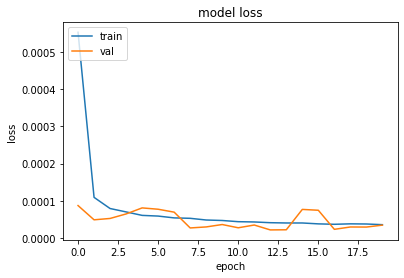

['loss', 'output1_loss', 'output2_loss', 'output3_loss', 'output4_loss', 'output5_loss', 'output6_loss', 'output1_mse', 'output2_mse', 'output3_mse', 'output4_mse', 'output5_mse', 'output6_mse']
[3.473258158487911e-05, 2.1651432689395733e-05, 6.490246596513316e-05, 4.0811861254042014e-05, 2.6092091502505355e-05, 4.17957162426319e-05, 2.1862510038772598e-05, 2.1651308998116292e-05, 6.490250962087885e-05, 4.0812199586071074e-05, 2.6091944164363667e-05, 4.1795832657953724e-05, 2.1862570065422915e-05]


In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
test_error_rate = model.evaluate(X_test,[y_test_price, y_test_delta, y_test_gamma, y_test_rho, y_test_vega, y_test_theta], verbose=0)
print(model.metrics_names)
print(test_error_rate)


In [74]:
model_json = model.to_json()
with open("model_basket_greeks.json", "w") as json_file:
    json_file.write(model_json)
        # serialize weights to HDF5
model.save_weights('model_weights_basket_greeks.h5')
print("Saved model weights to disk")

Saved model weights to disk


In [5]:
from keras.models import model_from_json

# load json and create model
json_file = open('model_basket_greeks.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
price_model = model_from_json(loaded_model_json)
price_model.load_weights("model_weights_basket_greeks.h5")
print("Loaded model from disk")
price_model.summary()

# evaluate loaded model on test data
price_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

Using TensorFlow backend.


Loaded model from disk
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 50)           450         input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 100)          5100        dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 100)          10100       dense_6[0][0]                    
_____________________________________________________________________

In [12]:
model = price_model
option = random_basket_options(1)
greeks = option[0].mm_price_greeks()
dataframe = pd.DataFrame([greeks])
dataframe.columns = ['s1', 's2', 'sigma1', 'sigma2', 'corr', 'strike_price', 'maturity', 'devidend','risk_free_rate','call_price','delta', 'gamma', 'rho', 'vega', 'theta']
mm_greeks = dataframe[['call_price', 'delta', 'gamma', 'vega','rho', 'theta']]
mm_greeks['method'] = 'mm'

input_training = scaler.transform(dataframe)
input_df = pd.DataFrame(input_training,columns=dataframe.columns.values)
model_input = input_df[['s1','s2','sigma1', 'sigma2', 'corr', 'strike_price', 'maturity', 'risk_free_rate']].values
time_greeks_dl_start = timer()
greek_predictions = model.predict(model_input)
#print(dataframe)
#print(greek_predictions)
time_greeks_dl_end = timer()
#print(scaler.min_)
#print(scaler.scale_)
for i in range(len(greek_predictions)):
    greek_predictions[i] = ((greek_predictions[i][0] - scaler.min_[9+i])/scaler.scale_[9+i])[0]
greek_predictions = [tuple(greek_predictions)]
greeks_results = pd.DataFrame(greek_predictions,columns=['call_price', 'delta', 'gamma','rho','vega', 'theta'])
greeks_results['method'] = 'multi-dl'
greeks_results['time'] = time_greeks_dl_end - time_greeks_dl_start

df_greeks = pd.concat([mm_greeks,greeks_results], sort=False).reset_index(drop=True)
df_greeks['price_diff'] = df_greeks['call_price']/df_greeks['call_price'].iat[0] - 1
df_greeks['delta_diff'] = df_greeks['delta']/df_greeks['delta'].iat[0] - 1
df_greeks['gamma_diff'] = df_greeks['gamma']/df_greeks['gamma'].iat[0] - 1
df_greeks['rho_diff'] = df_greeks['rho']/df_greeks['rho'].iat[0] - 1
df_greeks['vega_diff'] = df_greeks['vega']/df_greeks['vega'].iat[0] - 1
df_greeks['theta_diff'] = df_greeks['theta']/df_greeks['theta'].iat[0] - 1

df_greeks.round(4)


e:\ucl\year 3\individual project\ml\nnforoptionspricing\venv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,call_price,delta,gamma,vega,rho,theta,method,time,price_diff,delta_diff,gamma_diff,rho_diff,vega_diff,theta_diff
0,20.7055,0.2587,0.0015,100.9675,82.6827,-9.7997,mm,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,22.3319,0.2622,0.0015,100.4566,82.7594,-10.0868,multi-dl,0.0022,0.0785,0.0134,-0.0142,0.0009,-0.0051,0.0293


In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

train = pd.read_pickle('basket_random_greeks_train_500k.pkl')
test = pd.read_pickle('basket_random_greeks_test_500k.pkl')
scaler = MinMaxScaler(feature_range=(0,1))
scaled_training = scaler.fit_transform(train)
scaled_testing = scaler.transform(test)
scaled_training_df = pd.DataFrame(scaled_training,columns=train.columns.values)
scaled_testing_df = pd.DataFrame(scaled_testing,columns=test.columns.values)

print("mutiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[6],scaler.min_[6]))
X_train = scaled_training_df[['s1','s2','sigma1', 'sigma2', 'corr', 'strike_price', 'maturity', 'risk_free_rate']].values
y_train = scaled_training_df['call_price'].values
X_test = scaled_testing_df[['s1','s2','sigma1', 'sigma2', 'corr', 'strike_price', 'maturity', 'risk_free_rate']].values
y_test = scaled_testing_df['call_price'].values

print("X:", X_train.shape, "Y:",y_train.shape)



mutiplying by 0.3336380256 and adding -0.001828
X: (400000, 8) Y: (400000,)


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import keras

model = Sequential()
model.add(Dense(50,input_dim=8,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

'''
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1)
]
'''

model.fit(X_train, y_train, epochs=10, validation_split=0.2,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))


Train on 320000 samples, validate on 80000 samples
Epoch 1/10
 - 29s - loss: 1.4209e-04 - val_loss: 9.2843e-05
Epoch 2/10
 - 28s - loss: 1.5041e-05 - val_loss: 1.2266e-05
Epoch 3/10
 - 28s - loss: 9.0278e-06 - val_loss: 4.6413e-06
Epoch 4/10
 - 28s - loss: 6.3728e-06 - val_loss: 3.9667e-06
Epoch 5/10
 - 28s - loss: 5.0998e-06 - val_loss: 2.1180e-06
Epoch 6/10
 - 28s - loss: 4.7151e-06 - val_loss: 2.8178e-06
Epoch 7/10
 - 29s - loss: 4.1773e-06 - val_loss: 2.6332e-06
Epoch 8/10
 - 29s - loss: 3.5688e-06 - val_loss: 1.6686e-06
Epoch 9/10
 - 28s - loss: 3.4534e-06 - val_loss: 1.5457e-06
Epoch 10/10
 - 30s - loss: 3.0463e-06 - val_loss: 4.6962e-06
The mean squared error (MSE) for the test data set is: 4.699742060416092e-06


In [12]:
from statistics import *
from math import sqrt
import matplotlib as mpl
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    stats['diff'].sort()

    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(8,6))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(8,6))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats

    
def CheckAccuracy_scaled(scale,y,y_hat):
    stats = dict()
    
    y = (y - scale.min_[6])/scale.scale_[6] 
    y_hat = (y_hat - scale.min_[6])/scaler.scale_[6] 
    stats['diff'] = y - y_hat
    stats['diff'].sort()
    
    stats['diff_percentage'] = 100 * stats['diff'] / y
    np.where(stats['diff_percentage'] > 1)
    print(stats['diff_percentage'])

    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(8,6))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(8,6))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    

Mean Squared Error:       4.6798245335141605e-06
Root Mean Squared Error:  0.0021632902101923726
Mean Absolute Error:      0.0015506233272863546
Mean Percent Error:       0.021421413973454116


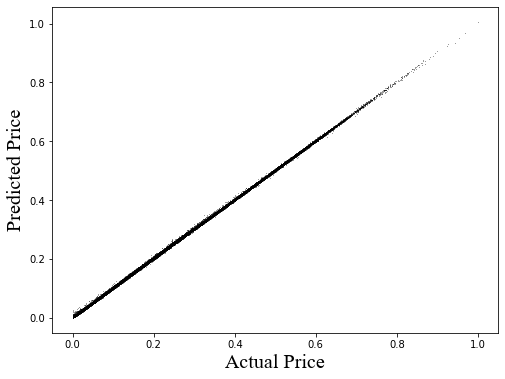

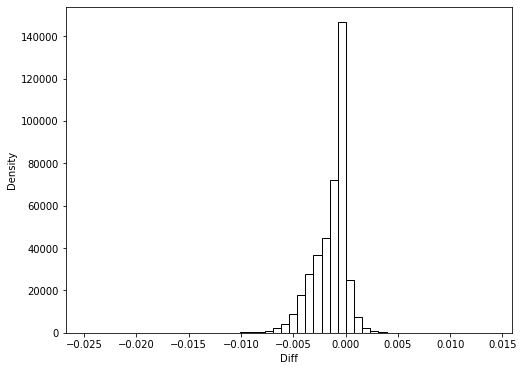

Mean Squared Error:       4.699741910354537e-06
Root Mean Squared Error:  0.0021678888141126004
Mean Absolute Error:      0.0015470475485235538
Mean Percent Error:       0.021537108798202562


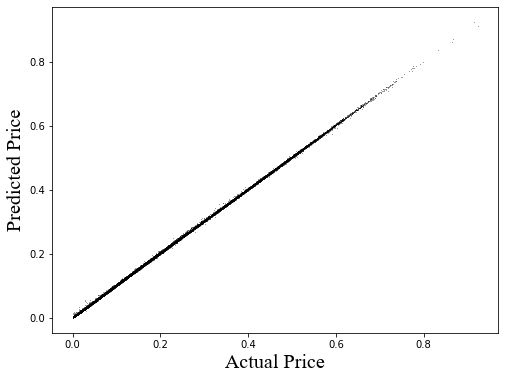

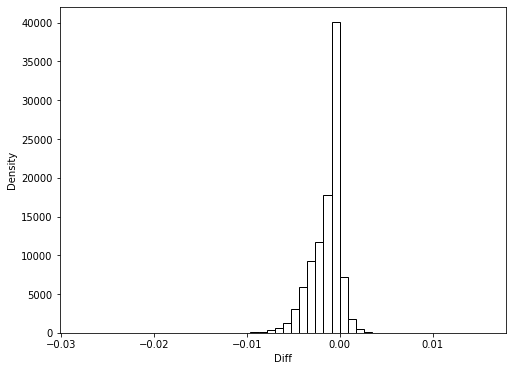

----------------------------------------------------------------------------------------------------
[ -18.81675461 -236.47781635   -8.60467326 ...    2.26813204  676.9407051
    5.51768628]
Mean Squared Error:       4.222066981802042e-05
Root Mean Squared Error:  0.006497743440458419
Mean Absolute Error:      0.00463691623818734
Mean Percent Error:       0.02115298327051301


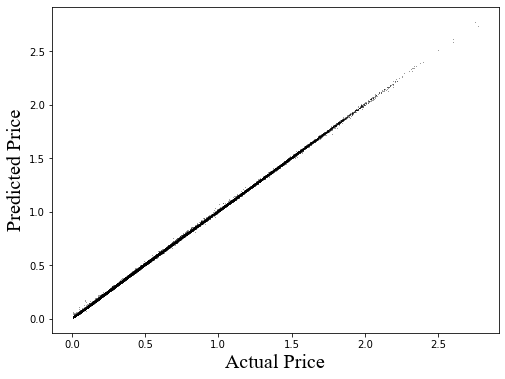

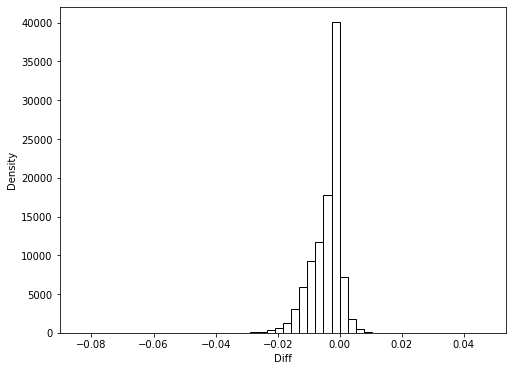

In [14]:
y_test_hat = model.predict(X_test)
y_test_hat = np.squeeze(y_test_hat)

y_train_hat = model.predict(X_train)
y_train_hat = np.squeeze(y_train_hat)

CheckAccuracy(y_train, y_train_hat)

CheckAccuracy(y_test, y_test_hat)
print('-'*100)
CheckAccuracy_scaled(scaler, y_test, y_test_hat)

In [12]:
print(y_test_hat.shape)

(99999,)
